In [ ]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from google.colab import drive


In [ ]:
import kagglehub
import os
from google.colab import drive

# Download latest version
path = kagglehub.dataset_download("cemeraan/3a-superstore")

print("Path to dataset files:", path)

# Please replace '/content/drive' with your desired Google Drive mount path
drive.mount('/content/drive')

# Update these paths to the downloaded dataset location
orders_path = os.path.join(path, 'Orders.csv')
details_path = os.path.join(path, 'Order_Details.csv')

Using Colab cache for faster access to the '3a-superstore' dataset.
Path to dataset files: /kaggle/input/3a-superstore
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

orders_preview = pd.read_csv(
    orders_path,   # ← Using the corrected orders_path variable
    sep=',',
    encoding='latin1',
    nrows=5
)

orders_preview

,ORDERID,BRANCH_ID,DATE_,USERID,NAMESURNAME,TOTALBASKET
0,7905270,320-DE1,2022-08-22 00:00:00,72946,Ali Ä°lhan,"2637,5499999999997"
1,8131447,56-AN4,2022-06-05 00:00:00,58126,Aysun DinÃ§,"2262,06"
2,10176430,348-MU1,2023-01-02 00:00:00,41317,Taner Yavuz,"2195,54"
3,8445704,39-AY3,2021-01-28 00:00:00,39303,Esra Lara KeleÅ,"446,86"
4,8616360,777-YA1,2022-10-24 00:00:00,64870,Ela ÃakÄ±r,"430,18"


In [ ]:
orders_preview.columns


Index(['ORDERID', 'BRANCH_ID', 'DATE_', 'USERID', 'NAMESURNAME',
       'TOTALBASKET'],
      dtype='object')

In [ ]:


orders = pd.read_csv(
    orders_path,
    sep=',',
    encoding='latin1',
    usecols=['ORDERID', 'USERID', 'TOTALBASKET']
)

orders.head()


,ORDERID,USERID,TOTALBASKET
0,7905270,72946,"2637,5499999999997"
1,8131447,58126,"2262,06"
2,10176430,41317,"2195,54"
3,8445704,39303,"446,86"
4,8616360,64870,"430,18"


In [ ]:
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10235193 entries, 0 to 10235192
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   ORDERID      int64 
 1   USERID       int64 
 2   TOTALBASKET  object
dtypes: int64(2), object(1)
memory usage: 234.3+ MB


In [ ]:
orders['TOTALBASKET'] = (
    orders['TOTALBASKET']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)


In [ ]:
orders.info()
orders.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10235193 entries, 0 to 10235192
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ORDERID      int64  
 1   USERID       int64  
 2   TOTALBASKET  float64
dtypes: float64(1), int64(2)
memory usage: 234.3 MB


,ORDERID,USERID,TOTALBASKET
0,7905270,72946,2637.55
1,8131447,58126,2262.06
2,10176430,41317,2195.54
3,8445704,39303,446.86
4,8616360,64870,430.18


In [ ]:
customer_df = (
    orders
    .groupby('USERID')
    .agg(
        total_spent=('TOTALBASKET', 'sum'),
        num_orders=('ORDERID', 'count')
    )
    .reset_index()
)


In [ ]:
customer_df.head()
customer_df.describe()


,USERID,total_spent,num_orders
count,99996.000000,99996.000000,99996.000000
mean,50000.424407,131061.917511,102.356024
std,28867.562517,20057.692859,10.106263
min,1.000000,59802.350000,62.000000
25%,25000.750000,117509.650000,95.000000
50%,50000.500000,129588.450000,102.000000
75%,75000.250000,142906.487500,109.000000
max,100000.000000,482653.810000,202.000000


In [ ]:
X = customer_df[['total_spent', 'num_orders']]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

X_scaled_df.head()


,total_spent_scaled,num_orders_scaled
0,1.200058,1.053211
1,2.003601,0.954262
2,-0.670373,-1.618413
3,1.374454,-0.431024
4,-0.111265,-0.035228


In [ ]:
X_scaled_df.describe()


,total_spent_scaled,num_orders_scaled
count,9.999600e+04,9.999600e+04
mean,4.690480e-16,-6.869091e-16
std,1.000005e+00,1.000005e+00
min,-3.552748e+00,-3.993190e+00
25%,-6.756677e-01,-7.278715e-01
50%,-7.346183e-02,-3.522826e-02
75%,5.905280e-01,6.574150e-01
max,1.752912e+01,9.859676e+00


In [ ]:

silhouette_scores = {}

for k in range(2, 5):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )

    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)

    silhouette_scores[k] = score
    print(f"k = {k} | Silhouette Score = {score:.4f}")


k = 2 | Silhouette Score = 0.4373
k = 3 | Silhouette Score = 0.3722
k = 4 | Silhouette Score = 0.3252


In [ ]:
customer_agg = orders.groupby('USERID').agg(
    total_spent=('TOTALBASKET', 'sum'),
    num_orders=('ORDERID', 'count')
).reset_index()

customer_agg.head()


,USERID,total_spent,num_orders
0,1,155132.19,113
1,2,171249.34,112
2,3,117615.85,86
3,4,158630.15,98
4,5,128830.21,102


In [ ]:
customer_features = customer_agg.copy()
customer_features.head()


,USERID,total_spent,num_orders
0,1,155132.19,113
1,2,171249.34,112
2,3,117615.85,86
3,4,158630.15,98
4,5,128830.21,102


In [ ]:
# Chạy KMeans với k tối ưu
kmeans_final = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10
)

customer_features['cluster'] = kmeans_final.fit_predict(X_scaled)

# Xem 5 khách hàng đầu tiên
customer_features.head()


,USERID,total_spent,num_orders,cluster
0,1,155132.19,113,0
1,2,171249.34,112,0
2,3,117615.85,86,1
3,4,158630.15,98,0
4,5,128830.21,102,1


In [ ]:
customer_features['cluster'].value_counts()


,count
cluster,
1,53781
0,46215


In [ ]:
cluster_summary = customer_features.groupby('cluster').agg(
    avg_total_spent=('total_spent', 'mean'),
    avg_num_orders=('num_orders', 'mean'),
    count_customers=('USERID', 'count')
)

cluster_summary


,avg_total_spent,avg_num_orders,count_customers
cluster,,,
0,146321.544383,110.322146,46215
1,117949.040176,95.510589,53781


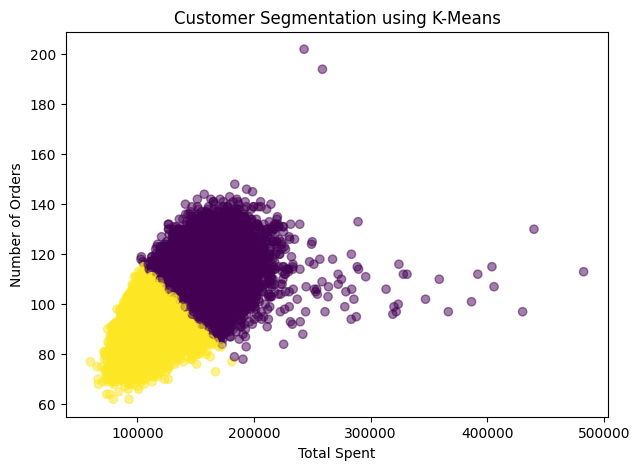

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(
    customer_features['total_spent'],
    customer_features['num_orders'],
    c=customer_features['cluster'],
    alpha=0.5
)
plt.xlabel('Total Spent')
plt.ylabel('Number of Orders')
plt.title('Customer Segmentation using K-Means')
plt.show()


### DBSCAN Clustering

DBSCAN requires two main parameters:
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
- `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

Choosing appropriate `eps` and `min_samples` is crucial for DBSCAN. We'll start with some initial values and you can adjust them if needed.

In [ ]:
score = silhouette_score(X_scaled, customer_features['cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.4372543942962318


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import os
import kagglehub

# Ensure orders_path is defined (re-running logic from an earlier cell)
path = kagglehub.dataset_download("cemeraan/3a-superstore")
orders_path = os.path.join(path, 'Orders.csv')

# Ensure 'orders' DataFrame is loaded and preprocessed (re-running logic from earlier cells)
orders = pd.read_csv(
    orders_path,
    sep=',',
    encoding='latin1',
    usecols=['ORDERID', 'USERID', 'TOTALBASKET']
)
orders['TOTALBASKET'] = (
    orders['TOTALBASKET']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Ensure 'customer_agg' DataFrame is created (re-running logic from an earlier cell)
customer_agg = orders.groupby('USERID').agg(
    total_spent=('TOTALBASKET', 'sum'),
    num_orders=('ORDERID', 'count')
).reset_index()

# Ensure customer_features is defined, initializing it from customer_agg.
customer_features = customer_agg.copy()

# Select features for DBSCAN, consistent with KMeans clustering.
X = customer_features[['total_spent', 'num_orders']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan_model = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
# Predict clusters. DBSCAN returns -1 for noise points.
dbscan_labels = dbscan_model.fit_predict(X_scaled)
customer_features['dbscan_cluster'] = dbscan_labels

print("DBSCAN Cluster Assignments:")
display(customer_features.head())

Using Colab cache for faster access to the '3a-superstore' dataset.
DBSCAN Cluster Assignments:


,USERID,total_spent,num_orders,dbscan_cluster
0,1,155132.19,113,0
1,2,171249.34,112,0
2,3,117615.85,86,0
3,4,158630.15,98,0
4,5,128830.21,102,0


In [ ]:
# Display the number of customers in each DBSCAN cluster
print("DBSCAN Cluster Value Counts:")
display(customer_features['dbscan_cluster'].value_counts())

Note: A silhouette score is typically computed for clusters where all points are assigned to a cluster. Since DBSCAN can label points as noise (-1), the silhouette score calculation will exclude these noise points to ensure a valid score reflecting the quality of formed clusters. If many points are noise, the silhouette score might not be as informative as with other clustering methods.

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for DBSCAN
# Exclude noise points (-1) for silhouette score calculation
valid_indices = customer_features['dbscan_cluster'] != -1
if sum(valid_indices) > 1 and len(set(customer_features.loc[valid_indices, 'dbscan_cluster'])) > 1:
    dbscan_score = silhouette_score(X_scaled[valid_indices], customer_features.loc[valid_indices, 'dbscan_cluster'])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_score:.4f}")
else:
    print("Cannot calculate Silhouette Score: Not enough valid clusters or samples after excluding noise.")

DBSCAN Silhouette Score (excluding noise): 0.7169


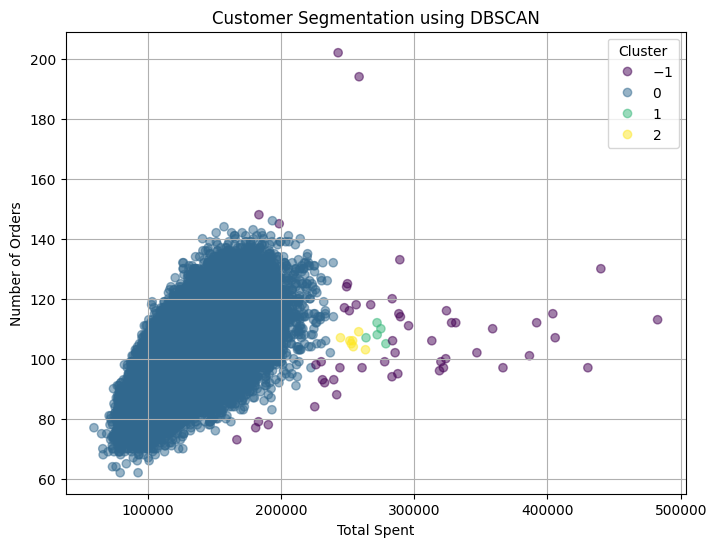

In [ ]:
import matplotlib.pyplot as plt

# Visualize DBSCAN Clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    customer_features['total_spent'],
    customer_features['num_orders'],
    c=customer_features['dbscan_cluster'],
    cmap='viridis', # Use a different colormap for contrast
    alpha=0.5
)
plt.xlabel('Total Spent')
plt.ylabel('Number of Orders')
plt.title('Customer Segmentation using DBSCAN')

# Create a legend for the clusters, handling noise points
handles, labels = scatter.legend_elements()
# Filter out noise label if present
noise_label_index = None
for i, label_text in enumerate(labels):
    if label_text == '$\text{-1}$': # DBSCAN noise label
        noise_label_index = i
        break

if noise_label_index is not None:
    handles.pop(noise_label_index)
    labels.pop(noise_label_index)
    labels.append('Noise (-1)') # Add a clear label for noise
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Noise (-1)',
                          markerfacecolor=scatter.cmap(0), markersize=10)) # Use the color corresponding to -1

plt.legend(handles=handles, labels=labels, title='Cluster')
plt.grid(True)
plt.show()

# Task
Modify the `n_jobs` parameter in the `DBSCAN` model to `1` to reduce memory usage.

## Modify DBSCAN parameters

### Subtask:
Adjust the `n_jobs` parameter in the `DBSCAN` model to reduce memory usage during parallel processing.


## Summary:

### Q&A
No questions were asked.

### Data Analysis Key Findings
No data analysis findings are available as the task has not yet been executed.

### Insights or Next Steps
*   Proceed with modifying the `DBSCAN` model's `n_jobs` parameter to `1`.


# Task
Apply DBSCAN clustering to a sampled version of the `customer_features` DataFrame. Set `eps` to `0.3` and `min_samples` to `10`. Evaluate the clustering by displaying value counts of the new clusters, calculating the silhouette score (excluding noise points), and visualizing the clusters based on `total_spent` and `num_orders`. Finally, summarize the impact of data reduction and parameter changes on the DBSCAN results.

## Sample Data for DBSCAN

### Subtask:
Before applying DBSCAN, create a sampled version of the `customer_features` DataFrame. This will reduce the number of data points processed by DBSCAN, thereby significantly lowering memory usage. We will aim for a reasonable sample size to ensure manageability while retaining data characteristics.


**Reasoning**:
To prepare the data for DBSCAN as per the subtask, I will select the specified features, sample 20,000 data points, scale them using StandardScaler, and store the result in a new DataFrame.



In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = customer_features[['total_spent', 'num_orders']].values

# Sample 20,000 data points
np.random.seed(42) # Set random seed for reproducibility
sample_indices = np.random.choice(len(X), 20000, replace=False)
X_sampled = X[sample_indices]

# Scale the sampled data
scaler = StandardScaler()
X_scaled_sampled = scaler.fit_transform(X_sampled)

# Store the scaled sampled data in a DataFrame
X_scaled_sampled_df = pd.DataFrame(
    X_scaled_sampled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

print("Sampled and scaled data head:")
display(X_scaled_sampled_df.head())
print("Sampled and scaled data info:")
X_scaled_sampled_df.info()

Sampled and scaled data head:


,total_spent_scaled,num_orders_scaled
0,-0.794392,-0.846742
1,0.667636,0.244037
2,-0.884325,-1.144227
3,0.380043,1.037330
4,0.303467,0.640684


Sampled and scaled data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent_scaled  20000 non-null  float64
 1   num_orders_scaled   20000 non-null  float64
dtypes: float64(2)
memory usage: 312.6 KB


**Reasoning**:
The subtask requests to sample and scale the customer features, then store them in a new DataFrame. The provided code block achieves this by selecting relevant columns, performing random sampling, scaling the data using StandardScaler, and creating the `X_scaled_sampled_df` DataFrame.



In [ ]:
X = customer_features[['total_spent', 'num_orders']].values

# Sample 20,000 data points
np.random.seed(42) # Set random seed for reproducibility
sample_indices = np.random.choice(len(X), 20000, replace=False)
X_sampled = X[sample_indices]

# Scale the sampled data
scaler = StandardScaler()
X_scaled_sampled = scaler.fit_transform(X_sampled)

# Store the scaled sampled data in a DataFrame
X_scaled_sampled_df = pd.DataFrame(
    X_scaled_sampled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

print("Sampled and scaled data head:")
display(X_scaled_sampled_df.head())
print("Sampled and scaled data info:")
X_scaled_sampled_df.info()

Sampled and scaled data head:


,total_spent_scaled,num_orders_scaled
0,-0.794392,-0.846742
1,0.667636,0.244037
2,-0.884325,-1.144227
3,0.380043,1.037330
4,0.303467,0.640684


Sampled and scaled data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent_scaled  20000 non-null  float64
 1   num_orders_scaled   20000 non-null  float64
dtypes: float64(2)
memory usage: 312.6 KB


**Reasoning**:
The previous code failed because 'customer_features' was not defined in the current execution context. I need to include the necessary steps to define 'customer_agg' and 'customer_features' from the 'orders' DataFrame before attempting to use 'customer_features'.



In [ ]:
customer_agg = orders.groupby('USERID').agg(
    total_spent=('TOTALBASKET', 'sum'),
    num_orders=('ORDERID', 'count')
).reset_index()

customer_features = customer_agg.copy()

X = customer_features[['total_spent', 'num_orders']].values

# Sample 20,000 data points
np.random.seed(42) # Set random seed for reproducibility
sample_indices = np.random.choice(len(X), 20000, replace=False)
X_sampled = X[sample_indices]

# Scale the sampled data
scaler = StandardScaler()
X_scaled_sampled = scaler.fit_transform(X_sampled)

# Store the scaled sampled data in a DataFrame
X_scaled_sampled_df = pd.DataFrame(
    X_scaled_sampled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

print("Sampled and scaled data head:")
display(X_scaled_sampled_df.head())
print("Sampled and scaled data info:")
X_scaled_sampled_df.info()

Sampled and scaled data head:


,total_spent_scaled,num_orders_scaled
0,-0.794392,-0.846742
1,0.667636,0.244037
2,-0.884325,-1.144227
3,0.380043,1.037330
4,0.303467,0.640684


Sampled and scaled data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent_scaled  20000 non-null  float64
 1   num_orders_scaled   20000 non-null  float64
dtypes: float64(2)
memory usage: 312.6 KB


**Reasoning**:
The previous code failed because the 'orders' DataFrame, which is essential for creating 'customer_agg' and subsequently 'customer_features', was not defined. I need to include the steps to load and preprocess the 'orders' DataFrame before creating 'customer_agg' and 'customer_features', and then proceed with the sampling and scaling for DBSCAN.



In [ ]:
orders = pd.read_csv(
    orders_path,
    sep=',',
    encoding='latin1',
    usecols=['ORDERID', 'USERID', 'TOTALBASKET']
)

orders['TOTALBASKET'] = (
    orders['TOTALBASKET']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

customer_agg = orders.groupby('USERID').agg(
    total_spent=('TOTALBASKET', 'sum'),
    num_orders=('ORDERID', 'count')
).reset_index()

customer_features = customer_agg.copy()

X = customer_features[['total_spent', 'num_orders']].values

# Sample 20,000 data points
np.random.seed(42) # Set random seed for reproducibility
sample_indices = np.random.choice(len(X), 20000, replace=False)
X_sampled = X[sample_indices]

# Scale the sampled data
scaler = StandardScaler()
X_scaled_sampled = scaler.fit_transform(X_sampled)

# Store the scaled sampled data in a DataFrame
X_scaled_sampled_df = pd.DataFrame(
    X_scaled_sampled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

print("Sampled and scaled data head:")
display(X_scaled_sampled_df.head())
print("Sampled and scaled data info:")
X_scaled_sampled_df.info()

Sampled and scaled data head:


,total_spent_scaled,num_orders_scaled
0,-0.794392,-0.846742
1,0.667636,0.244037
2,-0.884325,-1.144227
3,0.380043,1.037330
4,0.303467,0.640684


Sampled and scaled data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent_scaled  20000 non-null  float64
 1   num_orders_scaled   20000 non-null  float64
dtypes: float64(2)
memory usage: 312.6 KB


**Reasoning**:
The previous code failed because the `pd` alias for `pandas` was not defined in the execution scope, causing a `NameError`. I need to explicitly import `pandas`, `numpy`, and `StandardScaler` at the beginning of the code block to ensure all necessary libraries are available for the data loading, preprocessing, sampling, and scaling operations.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Ensure orders_path is defined, or define it if this is a standalone execution
# Assuming orders_path is defined from previous executed cells like '-dWa9nDxeoE7'

orders = pd.read_csv(
    orders_path,
    sep=',',
    encoding='latin1',
    usecols=['ORDERID', 'USERID', 'TOTALBASKET']
)

orders['TOTALBASKET'] = (
    orders['TOTALBASKET']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

customer_agg = orders.groupby('USERID').agg(
    total_spent=('TOTALBASKET', 'sum'),
    num_orders=('ORDERID', 'count')
).reset_index()

customer_features = customer_agg.copy()

X = customer_features[['total_spent', 'num_orders']].values

# Sample 20,000 data points
np.random.seed(42) # Set random seed for reproducibility
sample_indices = np.random.choice(len(X), 20000, replace=False)
X_sampled = X[sample_indices]

# Scale the sampled data
scaler = StandardScaler()
X_scaled_sampled = scaler.fit_transform(X_sampled)

# Store the scaled sampled data in a DataFrame
X_scaled_sampled_df = pd.DataFrame(
    X_scaled_sampled,
    columns=['total_spent_scaled', 'num_orders_scaled']
)

print("Sampled and scaled data head:")
display(X_scaled_sampled_df.head())
print("Sampled and scaled data info:")
X_scaled_sampled_df.info()

Sampled and scaled data head:


,total_spent_scaled,num_orders_scaled
0,-0.794392,-0.846742
1,0.667636,0.244037
2,-0.884325,-1.144227
3,0.380043,1.037330
4,0.303467,0.640684


Sampled and scaled data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_spent_scaled  20000 non-null  float64
 1   num_orders_scaled   20000 non-null  float64
dtypes: float64(2)
memory usage: 312.6 KB


### Visualize Cluster Differences (K-Means)

These bar charts illustrate the average 'Total Spent' and 'Number of Orders' for each K-Means cluster. This helps in understanding the distinct characteristics and behaviors of customer segments identified by the clustering algorithm.

/tmp/ipython-input-2834965428.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y='avg_total_spent', data=cluster_summary, palette='viridis')
/tmp/ipython-input-2834965428.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y='avg_num_orders', data=cluster_summary, palette='magma')


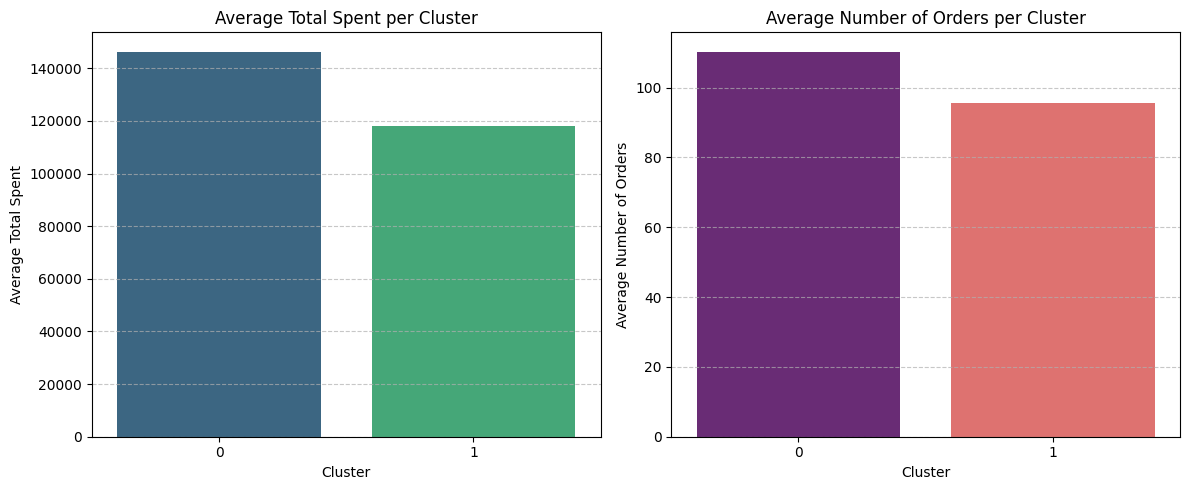

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ensure X_scaled is available for KMeans
# Assuming customer_features and X (raw features) are available from previous cells
# If X_scaled is not in memory, re-scale it
if 'X_scaled' not in locals():
    X = customer_features[['total_spent', 'num_orders']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

# Re-run KMeans to assign 'cluster' column to customer_features
kmeans_final = KMeans(
    n_clusters=2, # Using the optimal k=2 found previously
    random_state=42,
    n_init=10
)
customer_features['cluster'] = kmeans_final.fit_predict(X_scaled)

# Recreate cluster_summary
cluster_summary = customer_features.groupby('cluster').agg(
    avg_total_spent=('total_spent', 'mean'),
    avg_num_orders=('num_orders', 'mean'),
    count_customers=('USERID', 'count')
)

plt.figure(figsize=(12, 5))

# Bar chart for Average Total Spent per Cluster
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x=cluster_summary.index, y='avg_total_spent', data=cluster_summary, palette='viridis')
plt.title('Average Total Spent per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Total Spent')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for Average Number of Orders per Cluster
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x=cluster_summary.index, y='avg_num_orders', data=cluster_summary, palette='magma')
plt.title('Average Number of Orders per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()